In [159]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv("flightData_ParkThrower.csv")
data = data.iloc[::2].reset_index()
Alt = data["Altitude"]
Acc_Z = data["AccX"]
Time = data["Time"].div(1000)

# import raw data to calculate sensor covariance from
raw_data = pd.read_csv("flightData_0_deg_raw.csv")
cov_mat = raw_data.iloc[200:1200][["Altitude", "AccX"]].cov()
print(cov_mat)

          Altitude      AccX
Altitude  0.092852 -0.055174
AccX     -0.055174  0.460889


In [160]:
def diff(X, T):
    V = []
    for i in range(1, len(X)):
        V.append((X[i]-X[i-1])/(T[i]-T[i-1]))
    return V

def integrate(X, T):
    V = [0]
    for i in range(1, len(X)):
        V.append(V[-1] + 0.5*(T[i]-T[i-1])*(X[i-1] + X[i]))
    return V

V_Baro = diff(Alt.tolist(), Time.tolist())
V_Acc = integrate(Acc_Z.tolist(), Time.tolist())


In [161]:
# Kalman Filter
def getF(delta_T):
    return np.array([[1, delta_T, 0.5*delta_T**2], [0, 1, delta_T], [0, 0, 1]])

Alt_pred = []
Vel_pred = []
Acc_pred = []

C = np.array([[1, 0, 0], [0, 0, 1]])
# State Vector
Xk = np.array([[0], [0], [0]])
# State Estimate Covariance
Pk = np.array([[0, 0, 0], [0, 0, 0], [0, 0, 0]])
# Sensor Covariance
#R = np.array([[0.0929, 0], [0, 0.4609]])
R = np.array([[0.001, 0], [0, 0.1]])
# Model Covariance
Q = np.array([[0.000001, 0, 0], [0, 0, 0], [0, 0, 0.1]])
for i in range(1, len(Time)):
    delta_T = Time[i] - Time[i-1]
    Y = np.array([[Alt[i]], [Acc_Z[i]]])
    F = getF(delta_T)
    Xkp_min = F.dot(Xk)
    Ykp_min = C.dot(Xkp_min)
    Pkp_min = F.dot(Pk).dot(np.transpose(F)) + Q
    K = Pkp_min.dot(np.transpose(C)).dot(np.linalg.inv(C.dot(Pkp_min).dot(np.transpose(C)) + R))
    Xk = Xkp_min + K.dot(Y - Ykp_min)
    Pk = (np.eye(3) - K.dot(C)).dot(Pkp_min)
    
    print(str(Xk[0][0])+','+str(Xk[1][0])+','+str(Xk[2][0]))
    
    Alt_pred.append(Xk[0][0])
    Vel_pred.append(Xk[1][0])
    Acc_pred.append(Xk[2][0])

    print("" + str(Xk[0][0]) + "," + str(Xk[1][0])+ "," + str(Xk[2][0]))



-0.0001898101898101898,0.0,0.055
-0.0006462937755433129,0.004530877870407171,0.2203430874489508
-0.0014603298270592273,0.001821816072963901,-0.23979167946106736
-0.003483238049596673,-0.02917473581830172,-0.9075938276833007
-0.00861708886245048,-0.09629539152268467,-1.4071829540561498
-0.017494270379774156,-0.17395954628880256,-1.4004258542750836
-0.02975557746117803,-0.23663532729010134,-0.7595652767676417
-0.041380632268818836,-0.2723183659872335,-0.7310766880406339
-0.054570130046773295,-0.318981392487802,-1.2630289417624718
-0.0664902170355977,-0.36722466214572275,-1.4810702353700393
-0.07728136735530933,-0.40539847560516135,-1.3034787089114481
-0.08672254965825772,-0.43145556294812415,-1.2643051116770447
-0.09501828065724804,-0.43716163124911606,-0.6127713878122495
-0.08330392821895723,-0.37583378447314786,-0.5526923877033943
-0.06790476729994205,-0.30964694380995456,-0.3270978155597225
-0.04414906820813166,-0.22963845735362143,-0.3147963972955781
-0.01864052253864052,-0.167919940

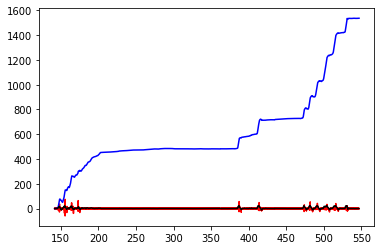

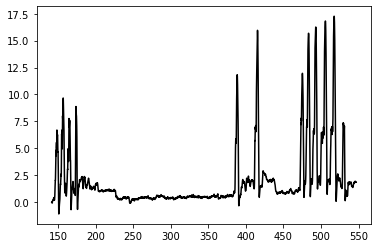

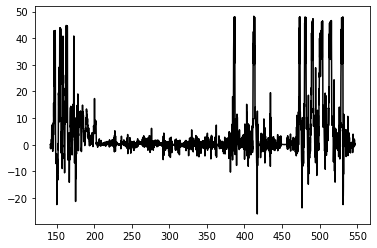

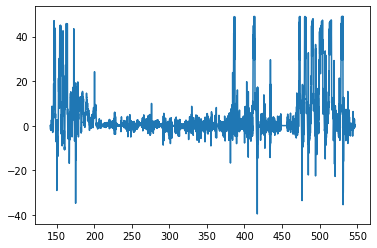

In [162]:
#plt.plot(Time, Alt)
#plt.show()
plt.plot(Time[:-1], V_Baro, 'r')
plt.plot(Time, V_Acc, 'b')
plt.plot(Time[:-1], Vel_pred, 'k')
plt.show()
plt.plot(Time[:-1], Alt_pred, 'k')
plt.show()
plt.plot(Time[:-1], Acc_pred, 'k')
plt.show()
plt.plot(Time, Acc_Z)
plt.show()